In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, Callable, Union, Optional
from tensor_type import Tensor
from scipy.stats import norm, expon, uniform, multivariate_normal
from torch import mm, exp, log, det, minimum, sqrt, mul
from torch.linalg import inv, det

import time
import pdb
import tqdm

In [ ]:
def improve_mass_matrix(minv: Tensor,
                        mu: Tensor,
                        n: int,
                        qs = List[Tensor]) -> Tensor:
    '''
    This function takes a list of the burn-in parameter points q
    and the current mass matrix to estimate an improved matrix
    minv: current mass matrix
    mu: mean of distribution
    n: number of burn-in points
    qs: lsit of parameter points
    returns the mean matrix of q.q^T and original minv
    '''
    #pdb.set_trace()
    minv = minv.clone()
    for i in range(n):
        a = qs[i] - mu  # create rank-1 matrix
        minv.add_(a.mm(a.t()))  # sum into minv
    
    return minv.div_(n)

# Unit Test
#test_list = [torch.tensor([[2.],[3.]]), torch.tensor([[1.],[4.]])]
#ident = torch.tensor([[1.,0.],[0.,1.]])
#zero = torch.zeros((2,1))
#improve_mass_matrix(ident,zero,2, test_list)

In [2]:
def KE(x:  Tensor,
       mu: Tensor,
       Minv: Optional[Tensor]=None,
       detM: Optional[float] =0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        ke = .5 * mm(x.t(), mm(Minv,x)) + const
    else:
        ke = .5 * mm(a.t(),a)
    return ke

def KE_2(x:  Tensor,
       mu1: Tensor,
       mu2: Tensor,
       Minv1: Optional[Tensor] = None,
       Minv2: Optional[Tensor] = None,
       detM1: Optional[float] = 0.0,
       detM2: Optional[float] = 0.0) -> Tensor:
    '''
    This is a kinetic energy function KE(x) = -log pi(p|q), where
    pi is of general form xT.A.x
    x: is a point
    mu: is the distribution mean
    '''
    #pdb.set_trace()
    a = x-mu1
    b = x-mu2
    if(torch.is_tensor(Minv1)):
        const = log(2*np.pi*np.sqrt(detM1)) + log(2*np.pi*np.sqrt(detM2)) - np.log(.6) - np.log(.4)
        ke = .5 * (mm(a.t(), mm(Minv1,a)) + mm(b.t(), mm(Minv2,b)) ) + const
    else:
        ke = .5 * mm(a.t(),a)
    return ke



def PE_1(x:  Tensor,
         mu: Tensor,
         Minv: Optional[Tensor] = None,
         detM: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu
    if(torch.is_tensor(Minv)):
        const = log(2*np.pi*np.sqrt(detM))
        pe = .5 * mm(a.t(), mm(Minv,a)) + const
    else:
        pe = .5 * mm(a.t(),a)
    return pe

def PE_2(x:  Tensor,
         mu1: Tensor,
         mu2: Tensor,
         Minv1: Optional[Tensor] = None,
         Minv2: Optional[Tensor] = None,
         detM1: Optional[float] = 0.0,
         detM2: Optional[float] = 0.0) -> Tensor:
    '''
    -log pi(q) where pi(q) is Gaussian 
    '''
    #pdb.set_trace()
    a = x-mu1
    b = x-mu2
    if(torch.is_tensor(Minv1)):
        const = log(2*np.pi*sqrt(detM1)) + log(2*np.pi*sqrt(detM2)) - np.log(.6) - np.log(.4)
        pe = .5 * (mm(a.t(), mm(Minv1,a)) + mm(b.t(), mm(Minv2,b)) ) + const
    else:
        pe = .5 * mm(a.t(),a)
    return pe

In [3]:
def get_autograd(func: Callable,
                 x:    Tensor,
                 mu1:   Tensor,
                 mu2:   Tensor,
                 Mat1:  Tensor,
                 Mat2:  Tensor,
                 detMat1: Optional[float] =0.0,
                 detMat2: Optional[float] =0.0) -> Tuple[Tensor, Tensor]:
    '''
    dH calculates K(p) or V(q) along with associated gradient.
    x: is a tensor
    Mat: is a mass matrix
    func: is the K or V function to calculate
    returns function output and gradient
    '''
    #pdb.set_trace()
    x.requires_grad_(True) # track math operations
    x.retain_grad() # keep gradient after backward()
    out = func(x, mu1, mu2, Mat1, Mat2, detMat1, detMat2)  # calculate given function
    out.backward(gradient=torch.ones(out.size()))  # Calculate grads
    x_grad = x.grad.data  # get gradients only
    x.grad = None  # reset gradient 
    x.requires_grad_(False)  # stop tracking
    return out.detach().clone(), x_grad 

# Unit Test
#t = torch.tensor([6., 4.]).view(2,1)
#tout, dt = dH(t, Minv, Tst2)

In [4]:
def stormer_verlet(V:    Callable,
                   q0:   Tensor,
                   p0:   Tensor,
                   mu1:   Tensor,
                   mu2:   Tensor,
                   Minv1: Tensor,
                   Minv2: Tensor,
                   detM1: Tensor,
                   detM2: Tensor,
                   eps:  float,
                   T:    int) -> Tuple[Tensor, Tensor]:
    '''
    Stormer-Verlet should propagate a point in phase space
    (p,q) according to Hamiltonian H.
    
    dVdq: references a function yielding the derivative of
    potential energy V.
    q0: is initial position tensor
    p0: is initial momentum tensor
    eps: scalar time increment
    T: time interval length
    returns numpy arrays q and p
    '''
    Nsteps = int(T//eps)
    q, p = q0.clone(), p0.clone()    
    for n in range(Nsteps-1):
        #pdb.set_trace()
        start = time.time()
        _, dHdq = get_autograd(V, q, mu1, mu2, Minv1, Minv2, detM1, detM2)
        d1 = time.time()-start
        
        p -= eps * dHdq/2 # half momentum step
        q += eps * p # full parameter step
        
    start = time.time()
    _, dHdq = get_autograd(V, q, mu1, mu2, Minv1, Minv2, detM1, detM2)
    d2 = time.time()-start
    p -= eps * dHdq # full momentum step
        
    #print(f'n={n}  derivative time {d1:.6f} --- {d2:.6f}')
    return q,-p 

In [5]:
def acceptance(q0: Tensor,
               p0: Tensor,
               q:  Tensor,
               p:  Tensor,
               mu1: Tensor,
               mu2: Tensor,
               Minv1: Optional[Tensor]=None,
               Minv2: Optional[Tensor]=None) -> Tuple[Tensor, bool]:
    '''
    This function calculates the acceptance ratio for a proposal point.
    as min(1, exp(deltaE)) and checks this against a random uniform observer
    value. 
    q,q0,p,p0: Tensors
    mu: Tensor
    Minv: Tensor
    Returns a point and a boolean flag denoting accept or not accept
    '''
    #pdb.set_trace()
    KE0, PE0       = KE_2(q0, mu1, mu2, Minv1, Minv2, detM1, detM2) , PE_2(p0, mu1, mu2, Minv1, Minv2, detM1, detM2) 
    KEstar, PEstar = KE_2(q, mu1, mu2, Minv1, Minv2, detM1, detM2)  , PE_2(p, mu1, mu2, Minv1, Minv2, detM1, detM2)
    ke_diff = exp((KE0 + PE0) - (KEstar + PEstar)).item()
    r = min(1., ke_diff)
    obs = uniform.rvs()
    if obs < r:
        point = q
        acceptFlag = True
    else:
        point = q0
        acceptFlag = False
    return point, acceptFlag

In [6]:
T = 10  # Full time-steps
eps = 0.1  # Discretization of time-steps
Nsteps = int(T//eps)
Nq = 10000  # Number of q's to test 
D = 2  # Dimension of q

m1 =[[1., 0.2],
     [0.2, 1.]]
M1 = torch.tensor(m1)
Minv1 = inv(M1)
detM1 = det(M1).type(torch.float32)
mu1 = torch.tensor([[-1.],[0.]],dtype=torch.float32)

m2 = [[1., -0.9], 
      [-0.9, 1.]]
M2 = torch.tensor(m2)
Minv2 = inv(M2)
detM2 = det(M2).type(torch.float32)
mu2 = torch.tensor([[2.],[1.]],dtype=torch.float32)

In [7]:
%%time

accepted = 0
rejected = 0

acceptedPoints = torch.zeros((D,Nq))

# Diagnostic
allPaths = qPath = torch.zeros((Nq, Nsteps, D))
pathFlag = []

# pre-select random q's
q0 = torch.tensor([[4.],[0.]])
Q0 = np.random.uniform(low=-.3, high=.3, size=(D,Nq)) #(2,100)

# Loop iterations
for n in tqdm.tqdm(range(Nq)):
    #print(f'Iter: {n}')
    qPath = torch.zeros((Nsteps,D))
    # sample a parameter point from Q-space
    q0 = torch.from_numpy(Q0[:,n]).reshape((2,1)).type(torch.float32)
    # sample momentum p0 from normal
    p0 = torch.from_numpy(norm.rvs(size = 2)).type(torch.float32).view(2,1)
    #print(p0.size())
    # q0,p0 are (2,1) tensors
    q, p = stormer_verlet(PE_2, q0, p0, mu1, mu2,
                          Minv1, Minv2, detM1, detM2, eps, T)
    q1, aFlag = acceptance(q0, p0, q, p, mu1, mu2, Minv1, Minv2)
    acceptedPoints[:,n] = torch.squeeze(q)

    if(aFlag):
        accepted +=1
    else:
        rejected +=1
    pathFlag.append(aFlag)
    allPaths[n,:,:] = qPath[:,:]
    #print(f'q={q1}    accepted={aFlag}')

print(f'Acceptance rate: {accepted/Nq}\n\n')    

100%|█████████████████████████████████████| 10000/10000 [05:49<00:00, 28.60it/s]

Acceptance rate: 0.4445


CPU times: user 5min 45s, sys: 1.97 s, total: 5min 47s
Wall time: 5min 49s


In [8]:
acceptedPoints_np = acceptedPoints.numpy()
allPaths_np = allPaths.numpy()
allPaths_np.shape

(10000, 99, 2)

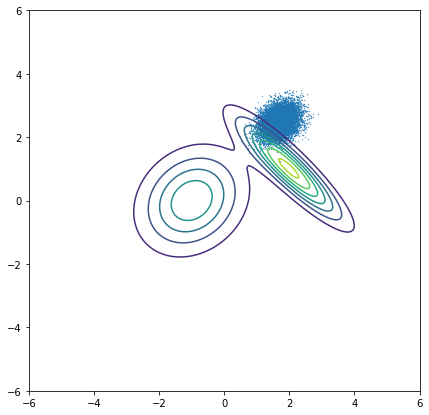

In [9]:
N    = 200
X    = np.linspace(-6, 6, N)
Y    = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)
pos  = np.dstack((X, Y))
rv1  = multivariate_normal([-1, 0], m1)
rv2  = multivariate_normal([2, 1], m2)
Z    = .6*rv1.pdf(pos) + .4*rv2.pdf(pos) 

plt.figure(figsize=(7,7))
plt.contour(X, Y, Z)
plt.scatter(acceptedPoints_np[0,:], acceptedPoints_np[1,:], s=.1)
plt.show()

In [10]:
-np.log(.6)-np.log(.4)

1.4271163556401456